In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
from torch.autograd import Variable
import torchvision
from torchvision import datasets, models, transforms, utils
import matplotlib.pyplot as plt
import time
from torch.utils.data import Dataset, DataLoader
from tqdm import tqdm
from sklearn.metrics import f1_score
from sklearn.model_selection import train_test_split
from PIL import Image

plt.ion()   # interactive mode


In [2]:
full_mean = 132.35524/255
full_std = 44.076332/255

In [3]:
class FacesDataset(Dataset):
    """Faces dataset."""

    def __init__(self, X, y, transform=None):
        self.image_vectors = X
        self.targets = y
        self.transform = transform

    def __len__(self):
        return len(self.image_vectors)

    def __getitem__(self, idx):

        one_dim_avg = self.image_vectors[idx]
        one_dim_image = np.reshape(one_dim_avg, (50, 37)).astype('uint8')
        im = Image.fromarray(one_dim_image)
        imrgb = Image.merge('RGB', (im, im, im))

        if self.transform:
            imrgb = self.transform(imrgb)

        return (imrgb, self.targets[idx])


In [4]:
# too: add more transforms later
data_transforms = {
    'train': transforms.Compose([
        transforms.Scale(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize(mean=[full_mean, full_mean, full_mean],
                             std=[full_std, full_std, full_std])
    ]),
    'val': transforms.Compose([
        transforms.Scale(224),
        transforms.ToTensor(),
        transforms.Normalize(mean=[full_mean, full_mean, full_mean],
                             std=[full_std, full_std, full_std])
    ]),
}

In [5]:

# %% loading the raw data
X_train_raw = np.load('X_train.npy')
y_train_raw = np.load('y_train.npy')

X_train, X_val, y_train, y_val = train_test_split(X_train_raw,
                                                  y_train_raw,
                                                  random_state=1)

faces_datasets = {
    'train': FacesDataset(X_train, y_train,
                          transform=data_transforms['train']),
    'val': FacesDataset(X_val, y_val, transform=data_transforms['val'])
}

dataloaders = {x: DataLoader(faces_datasets[x], batch_size=4,
                             shuffle=True, num_workers=4)
               for x in ['train', 'val']}

dataset_sizes = {x: len(faces_datasets[x]) for x in ['train', 'val']}
use_gpu = torch.cuda.is_available()


In [6]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    best_model_wts = model.state_dict()
    best_f1 = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        for phase in ['train', 'val']:
            if phase == 'train':
                scheduler.step()
                model.train(True)
            else:
                model.train(False)

            running_loss = 0.0
            running_labels = torch.LongTensor()
            running_predictions = torch.LongTensor()

            for data in tqdm(dataloaders[phase]):
                inputs, labels = data

                if use_gpu:
                    inputs = Variable(inputs.cuda())
                    labels = Variable(labels.cuda())
                else:
                    inputs, labels = Variable(inputs), Variable(labels)

                optimizer.zero_grad()

                # forward
                outputs = model(inputs)
                _, preds = torch.max(outputs.data, 1)
                loss = criterion(outputs, labels)

                if phase == 'train':
                    loss.backward()
                    optimizer.step()

                running_loss += loss.data[0]
                running_labels = torch.cat((running_labels, labels.data), 0)
                running_predictions = torch.cat((running_predictions, preds), 0)

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_f1 = f1_score(running_labels.numpy(), running_predictions.numpy(), average='macro')

            print('{} Loss: {:.4f} F1: {:.4f}'.format(
                    phase, epoch_loss, epoch_f1))

            if phase == 'val' and epoch_f1 > best_f1:
                best_f1 = epoch_f1
                best_model_wts = model.state_dict()

        print()
    time_elasped = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
            time_elasped // 60, time_elasped % 60))
    print('Best val F1: {:4f}'.format(best_f1))

    model.load_state_dict(best_model_wts)
    return model


In [7]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([full_mean, full_mean, full_mean])
    std = np.array([full_std, full_std, full_std])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


In [8]:
def visualize_model(model, num_images=6):
    images_so_far = 0
    fig = plt.figure()

    for i, data in enumerate(dataloaders['val']):
        inputs, labels = data
        if use_gpu:
            inputs, labels = Variable(inputs.cuda()), Variable(labels.cuda())
        else:
            inputs, labels = Variable(inputs), Variable(labels)

        outputs = model(inputs)
        _, preds = torch.max(outputs.data, 1)

        for j in range(inputs.size()[0]):
            images_so_far += 1
            ax = plt.subplot(num_images//2, 2, images_so_far)
            ax.axis('off')
            ax.set_title('predicted: {}'.format(preds[j]))
            imshow(inputs.cpu().data[j])

            if images_so_far == num_images:
                return


Epoch 0/0
----------
train Loss: 0.2517 F1: 0.5414
val Loss: 0.0621 F1: 0.8777

Training complete in 5m 58s
Best val F1: 0.877680


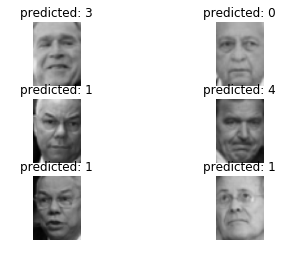

In [24]:
model_ft = models.resnet18(pretrained=True)
# swap out the last layer
num_ftrs = model_ft.fc.in_features
model_ft.fc = nn.Linear(num_ftrs, 7)

criterion = nn.CrossEntropyLoss()

# todo: Try adam
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

num_epochs = 25

model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler,
                       num_epochs)

visualize_model(model_ft)
plt.ioff()
plt.show()

In [ ]:
# save model parameters only
torch.save(model_ft.state_dict(), 'resnet18_{}epochs.pt'.format(num_epochs))

# save entire model
torch.save(model_ft, 'resnet18_{}epochs.model'.format(num_epochs))

In [26]:
# write code to run on test data
X_test_raw = np.load('X_test.npy')

test_dataset = FacesDataset(X_test_raw, np.zeros(X_test_raw.shape),
                            transform=data_transforms['val'])

test_dataloader = DataLoader(test_dataset, batch_size=4, num_workers=4)

model = torch.load('resnet18_24epochs.model')
model.eval()

results = np.array([])

for i, data in enumerate(tqdm(test_dataloader)):
        inputs, _ = data
        if use_gpu:
            inputs = Variable(inputs.cuda())
        else:
            inputs = Variable(inputs)

        outputs = model(inputs)
        _, preds = torch.max(outputs.data, 1)
        results = np.append(results, preds.numpy())

# save output predictions of test data
with open('output.csv', 'w') as f:
    f.write('ImageId,PredictedClass\n')
    for i in range(len(X_test_raw)):
        f.write('{},{}\n'.format(i, int(results[i])))

100%|██████████| 81/81 [00:47<00:00,  1.70it/s]


In [ ]:
# write code to train on train + val

In [ ]:
# write code to train on test again